**Phys 129L Section 8B** <br>
2/27/25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi

# Task 1: Quadrature

**A)**

In [1]:
class Quadrature:
    def __init__(self, func, a, b, n):
        """
        Initializes the Quadrature class.
        
        Parameters:
        func : function
            The function to integrate.
        a : float
            The lower limit of integration.
        b : float
            The upper limit of integration.
        n : int
            The number of subintervals (should be even for Simpson's rule).
        """
        self.func = func
        self.a = a
        self.b = b
        self.n = n
    
    def midpoint_rule(self):
        """Approximates the integral using the midpoint rule."""
        h = (self.b - self.a) / self.n
        result = 0.0
        for i in range(self.n):
            x_mid = self.a + (i + 0.5) * h
            result += self.func(x_mid)
        return result * h
    
    def trapezoidal_rule(self):
        """Approximates the integral using the trapezoidal rule."""
        h = (self.b - self.a) / self.n
        result = 0.5 * (self.func(self.a) + self.func(self.b))
        for i in range(1, self.n):
            x_i = self.a + i * h
            result += self.func(x_i)
        return result * h
    
    def simpsons_rule(self):
        """Approximates the integral using Simpson's rule."""
        if self.n % 2 == 1:
            raise ValueError("n must be even for Simpson's rule.")
        
        h = (self.b - self.a) / self.n
        result = self.func(self.a) + self.func(self.b)
        
        for i in range(1, self.n, 2):
            result += 4 * self.func(self.a + i * h)
        for i in range(2, self.n-1, 2):
            result += 2 * self.func(self.a + i * h)
        
        return result * h / 3

**B)**

In [31]:
# Class that doesn't depend on any external packages

class Quadrature:
    def midpoint_rule(self, func, a, b, n):
        """Approximates the integral using the midpoint rule."""
        h = (b - a) / n
        result = sum(func(a + (i + 0.5) * h) for i in range(n))
        return result * h
    
    def trapezoidal_rule(self, func, a, b, n):
        """Approximates the integral using the trapezoidal rule."""
        h = (b - a) / n
        result = 0.5 * (func(a) + func(b)) + sum(func(a + i * h) for i in range(1, n))
        return result * h
    
    def simpsons_rule(self, func, a, b, n):
        """Approximates the integral using Simpson's rule."""
        if n % 2 == 1:
            n += 1  # Ensure even n
        h = (b - a) / n
        result = func(a) + func(b) + 4 * sum(func(a + i * h) for i in range(1, n, 2)) + 2 * sum(func(a + i * h) for i in range(2, n-1, 2))
        return result * h / 3

**C) Gauss-Legendre Quadrature**

To transform the integral from $[-1,1]$ to $[a,b]$, we use the change of variable:

$$
x = \frac{b-a}{2} \xi + \frac{a+b}{2}
$$

where \(\xi\) is in the interval \([-1,1]\). The differential transformation follows:

$$
dx = \frac{b-a}{2} d\xi.
$$

Applying this transformation to the integral,

$$
\int_a^b f(x) dx = \int_{-1}^{1} f\left(\frac{b-a}{2} \xi + \frac{a+b}{2} \right) \frac{b-a}{2} d\xi.
$$

Using Gauss-Legendre quadrature, we approximate the integral as:

$$
\int_{-1}^{1} f(x) dx \approx \sum_{i=1}^{N} w_i f(x_i).
$$

Substituting our transformation,

$$
\int_a^b f(x) dx \approx \frac{b-a}{2} \sum_{i=1}^{N} w_i f \left(\frac{b-a}{2} x_i + \frac{a+b}{2} \right).
$$

This final expression confirms the desired result. It shows that integrating $ f(x) $ over $ [a,b] $ using Gauss-Legendre quadrature requires scaling the weights and evaluating the function at transformed quadrature nodes.

**D) Legendre Polynomials** 

In [21]:
class GaussQuad(Quadrature):
    def __init__(self, order):
        self.order = order
    
    def legendre_polynomial(self, M):
        """Computes the order-M Legendre polynomial using recursion."""
        if M == 0:
            return lambda x: 1
        elif M == 1:
            return lambda x: x
        else:
            P_prev = self.legendre_polynomial(M - 1)
            P_prev_prev = self.legendre_polynomial(M - 2)
            return lambda x: ((2 * M - 1) * x * P_prev(x) - (M - 1) * P_prev_prev(x)) / M
        
    def legendre_derivative(self, M):
        """Computes the derivative of the order-M Legendre polynomial."""
        P_M = self.legendre_polynomial(M)
        P_M_minus_1 = self.legendre_polynomial(M - 1)
        return lambda x: M / (x**2 - 1) * (x * P_M(x) - P_M_minus_1(x))
    
    def find_roots(self, M, tol=1e-10, max_iter=100):
        """Finds the roots of the order-M Legendre polynomial using Newton's method."""
        P_M = self.legendre_polynomial(M)
        P_M_prime = self.legendre_derivative(M)
        
        roots = np.cos(np.pi * (np.arange(1, M + 1) - 0.25) / (M + 0.5))  # Initial guess
        for _ in range(max_iter):
            delta = P_M(roots) / P_M_prime(roots)
            roots -= delta
            if np.max(np.abs(delta)) < tol:
                break
        return roots
    
    def compute_weights(self, M):
        """Computes the weights for Gauss-Legendre Quadrature."""
        roots = self.find_roots(M)
        P_M_prime = self.legendre_derivative(M)
        weights = 2 / ((1 - roots**2) * (P_M_prime(roots)**2))
        return roots, weights
    
    def save_roots_and_weights(self, orders, filename="gauss_quad_data.txt"):
        """Saves the roots and weights for multiple orders to a text file."""
        with open(filename, "w") as f:
            for M in orders:
                roots, weights = self.compute_weights(M)
                f.write(f"Order {M} \n")
                f.write("Roots: " + " ".join(map(str, roots)) + "\n")
                f.write("Weights: " + " ".join(map(str, weights)) + "\n\n")

    def plot_legendre_polynomials(self, orders=[1, 2, 3, 4, 5]):
        """Plots Legendre polynomials for given orders."""
        x = np.linspace(-1, 1, 1000)
        plt.figure(figsize=(8, 6))
        for M in orders:
            P_M = self.legendre_polynomial(M)
            plt.plot(x, [P_M(xi) for xi in x], label=f'P_{M}(x)')
        
        plt.xlabel('x')
        plt.ylabel('P_M(x)')
        plt.title('Legendre Polynomials')
        plt.legend()
        plt.grid()
        plt.savefig(f'Legendre_Polynomials_Orders_{orders}.png')
        plt.show()

    def integrate(self, func, a, b, M):
        """Computes the integral using Gauss-Legendre quadrature."""
        roots, weights = self.compute_weights(M)
        transformed_roots = 0.5 * (b - a) * roots + 0.5 * (a + b)
        return 0.5 * (b - a) * np.sum(weights * func(transformed_roots))

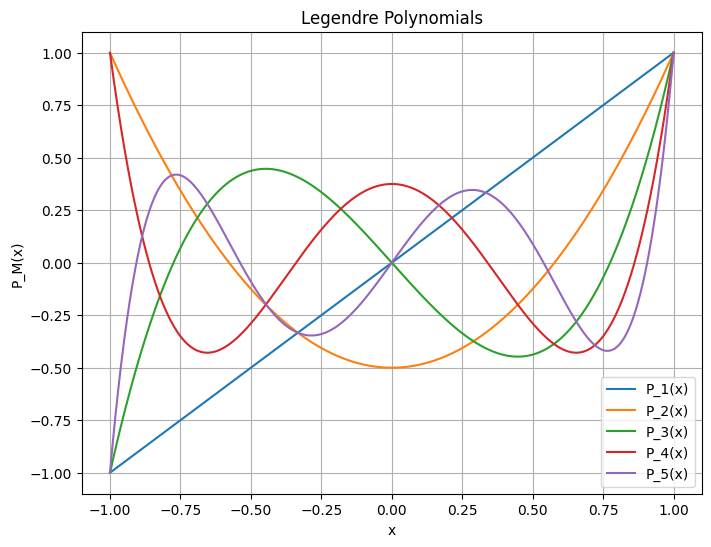

In [22]:
# Example usage
quad = GaussQuad(order=5)
quad.plot_legendre_polynomials()

**E) Newton's Method**

In [23]:
# Example usage
quad = GaussQuad(order=5)
roots, weights = quad.compute_weights(5)
print("Roots:", roots)
print("Weights:", weights)
quad.save_roots_and_weights([1, 2, 3, 4, 5])

Roots: [ 0.90617985  0.53846931  0.         -0.53846931 -0.90617985]
Weights: [0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]


# Task 2: Quadrature on Test Functions

**A) General k-th order polynomial**

In [32]:
def relative_error(true_value, approx_value):
    return abs((2 * true_value - approx_value) / (true_value + approx_value))

def generate_heatmaps():
    a, b = 0, 1
    k_values = np.arange(0, 11)
    N_values = np.logspace(1, 5, num=50, dtype=int)
    
    errors = {method: np.zeros((len(k_values), len(N_values))) for method in ['mid', 'trapz', 'simpson', 'gauss']}
    quad = GaussQuad(order=10)
    
    for i, k in enumerate(k_values):
        I_true = (b**(k+1) - a**(k+1)) / (k+1)
        func = lambda x: x**k
        
        for j, N in enumerate(N_values):
            errors['mid'][i, j] = relative_error(I_true, quad.midpoint_rule(func, a, b, N))
            errors['trapz'][i, j] = relative_error(I_true, quad.trapezoidal_rule(func, a, b, N))
            errors['simpson'][i, j] = relative_error(I_true, quad.simpsons_rule(func, a, b, N))
            errors['gauss'][i, j] = relative_error(I_true, quad.integrate(func, a, b, 10))
    
    for method, error_matrix in errors.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(error_matrix, xticklabels=N_values, yticklabels=k_values, norm=plt.Normalize(vmin=0, vmax=1), cmap='viridis')
        plt.xlabel('N (Number of Points)')
        plt.ylabel('k (Polynomial Order)')
        plt.title(f'Relative Error Heatmap - {method.capitalize()} Quadrature')
        plt.show()

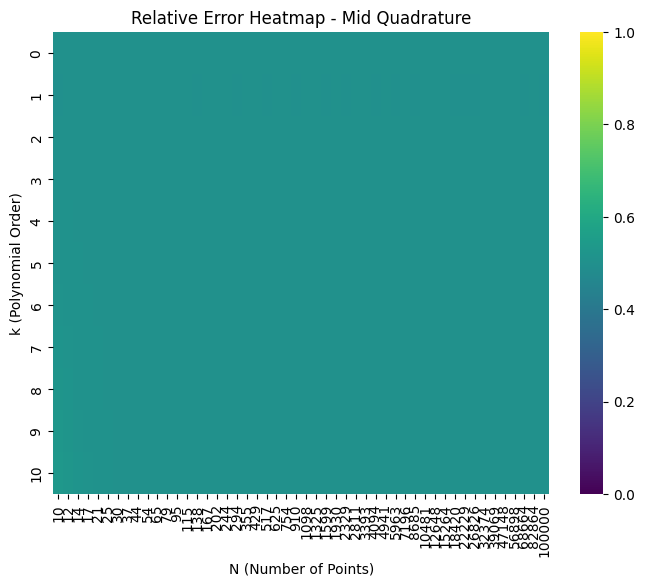

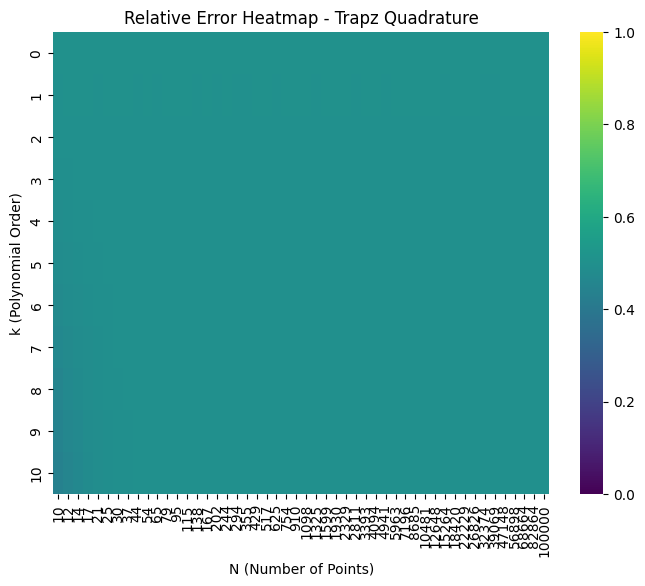

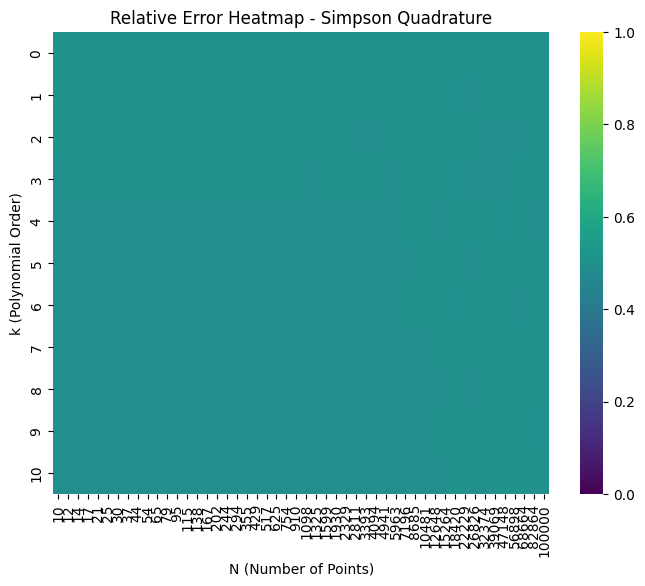

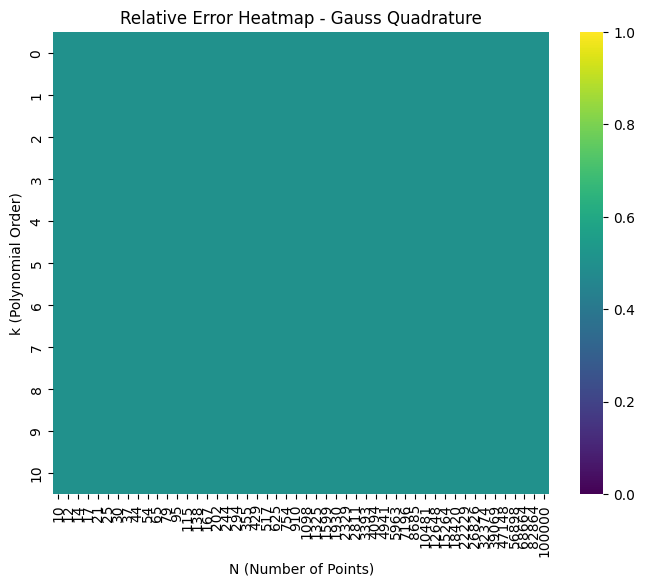

In [33]:
# Run heatmap generation
generate_heatmaps()

In [35]:
quad = Quadrature()  # Create an instance of the class

for k in range(0, 11):
    for N in [10, 100, 1000, 10000]:  # Test some values
        f = lambda x: x**k  # Define the polynomial function
        print(f'k={k}, N={N}, Midpoint={quad.midpoint_rule(f, 0, 1, N)}, '
              f'Trapezoidal={quad.trapezoidal_rule(f, 0, 1, N)}, '
              f'Simpson={quad.simpsons_rule(f, 0, 1, N)}')

k=0, N=10, Midpoint=1.0, Trapezoidal=1.0, Simpson=1.0
k=0, N=100, Midpoint=1.0, Trapezoidal=1.0, Simpson=1.0
k=0, N=1000, Midpoint=1.0, Trapezoidal=1.0, Simpson=1.0
k=0, N=10000, Midpoint=1.0, Trapezoidal=1.0, Simpson=1.0
k=1, N=10, Midpoint=0.5000000000000001, Trapezoidal=0.5000000000000001, Simpson=0.5
k=1, N=100, Midpoint=0.5, Trapezoidal=0.5, Simpson=0.5
k=1, N=1000, Midpoint=0.5, Trapezoidal=0.5, Simpson=0.5000000000000001
k=1, N=10000, Midpoint=0.5000000000000007, Trapezoidal=0.4999999999999991, Simpson=0.5
k=2, N=10, Midpoint=0.3325, Trapezoidal=0.3350000000000001, Simpson=0.3333333333333333
k=2, N=100, Midpoint=0.333325, Trapezoidal=0.33335000000000004, Simpson=0.3333333333333333
k=2, N=1000, Midpoint=0.33333324999999997, Trapezoidal=0.33333349999999995, Simpson=0.3333333333333334
k=2, N=10000, Midpoint=0.33333333249999875, Trapezoidal=0.33333333499999834, Simpson=0.33333333333333354
k=3, N=10, Midpoint=0.24875000000000003, Trapezoidal=0.25250000000000006, Simpson=0.25000000000

In [ ]:
N_values = np.logspace(1, 5, num=50, dtype=int)

for k in range(0, 11):
    for N in N_values:
        print(f"k={k}, N={N}, ΔM={delta_midpoint[k, N]:.5e}, ΔT={delta_trapezoidal[k, N]:.5e}, ΔS={delta_simpson[k, N]:.5e}, ΔG={delta_gauss[k, N]:.5e}")


In [38]:
def gauss_legendre_rule(f, a, b, N):
    """
    Compute the integral of f(x) from a to b using N-point Gauss-Legendre quadrature.
    
    Parameters:
        f (function): Function to integrate.
        a (float): Lower limit.
        b (float): Upper limit.
        N (int): Number of quadrature points.
    
    Returns:
        float: Approximated integral.
    """
    # Get the Gauss-Legendre nodes and weights
    nodes, weights = np.polynomial.legendre.leggauss(N)

    # Transform nodes from [-1,1] to [a,b]
    transformed_nodes = 0.5 * (b - a) * nodes + 0.5 * (b + a)
    transformed_weights = 0.5 * (b - a) * weights

    # Compute weighted sum
    integral = np.sum(transformed_weights * f(transformed_nodes))

    return integral

In [39]:
def true_integral(k):
    return 1 / (k + 1)

N_values = np.logspace(1, 5, num=50, dtype=int)  # Logarithmically spaced N values
k_values = np.arange(0, 11)  # k from 0 to 10

midpoint_errors = np.zeros((len(k_values), len(N_values)))
trapezoidal_errors = np.zeros((len(k_values), len(N_values)))
simpson_errors = np.zeros((len(k_values), len(N_values)))
gauss_errors = np.zeros((len(k_values), len(N_values)))

for i, k in enumerate(k_values):
    I_true = true_integral(k)
    
    for j, N in enumerate(N_values):
        M_kN = quad.midpoint_rule(lambda x: x**k, 0, 1, N)
        T_kN = quad.trapezoidal_rule(lambda x: x**k, 0, 1, N)
        S_kN = quad.simpsons_rule(lambda x: x**k, 0, 1, N)
        G_kN = gauss_legendre_rule(lambda x: x**k, 0, 1, N)
        
        # Compute relative errors
        midpoint_errors[i, j] = abs((2 * I_true - M_kN) / (I_true + M_kN))
        trapezoidal_errors[i, j] = abs((2 * I_true - T_kN) / (I_true + T_kN))
        simpson_errors[i, j] = abs((2 * I_true - S_kN) / (I_true + S_kN))
        gauss_errors[i, j] = abs((2 * I_true - G_kN) / (I_true + G_kN))

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

methods = ["Midpoint", "Trapezoidal", "Simpson's", "Gauss-Legendre"]
error_data = [midpoint_errors, trapezoidal_errors, simpson_errors, gauss_errors]

for ax, error, method in zip(axes.flat, error_data, methods):
    sns.heatmap(error, ax=ax, cmap="viridis", norm=LogNorm(), xticklabels=5, yticklabels=1)
    ax.set_title(f"{method} Rule Relative Error")
    ax.set_xlabel("N (log scale)")
    ax.set_ylabel("Polynomial Order k")

plt.tight_layout()
plt.show()


: 

**B) Fermi-Dirac Distribution**

# Task 3: Harmonic Oscillator

**A)**

In [4]:
def period_fixed_quad(a, N):
    """
    Computes the period of oscillation for a given amplitude 'a'
    using the fixed quadrature method with 'N' points.
    """
    if a <= 0:
        raise ValueError("Amplitude must be positive.")
    
    integrand = lambda x: 1 / np.sqrt(a**4 - x**4)
    integral, _ = spi.fixed_quad(integrand, 0, a, n=N)
    
    return np.sqrt(8) * integral

**B)**

In [5]:
a = 2.0  # Set the amplitude
N_values = [2, 4, 8, 16]  # Different values of N

for N in N_values:
    T_N = period_fixed_quad(a, N)
    T_2N = period_fixed_quad(a, 2 * N)
    error = abs(T_2N - T_N)
    print(f"N = {N}, Period = {T_N}, Error = {error}")

N = 2, Period = 1.6108746163618466, Error = 0.10686891159115475
N = 4, Period = 1.7177435279530013, Error = 0.0639707774321574
N = 8, Period = 1.7817143053851587, Error = 0.0350567498506027
N = 16, Period = 1.8167710552357614, Error = 0.018361179742043765


In [6]:
# Finding the minimum N where error < 10^(-4)
N = 2
error_threshold = 1e-4

while True:
    T_N = period_fixed_quad(a, N)
    T_2N = period_fixed_quad(a, 2 * N)
    error = abs(T_2N - T_N)
    
    if error < error_threshold:
        break
    N *= 2

print(f"Minimum N where error < {error_threshold}: {N}")

Minimum N where error < 0.0001: 4096


**C)**

In [7]:
def period_quad(a):
    """
    Computes the period of oscillation for a given amplitude 'a'
    using the adaptive quadrature method.
    """
    if a <= 0:
        raise ValueError("Amplitude must be positive.")
    
    integrand = lambda x: 1 / np.sqrt(a**4 - x**4)
    integral, error_estimate = spi.quad(integrand, 0, a)
    
    return np.sqrt(8) * integral, error_estimate

In [8]:
# Compare with quad function
T_quad, error_quad = period_quad(a)
print(f"Adaptive quadrature period: {T_quad}, Estimated error: {error_quad}")

Adaptive quadrature period: 1.854074677301701, Estimated error: 7.095168896853465e-11


**D)**

In [11]:
def period_romberg(a):
    """
    Computes the period of oscillation using Romberg integration.
    """
    if a <= 0:
        raise ValueError("Amplitude must be positive.")
    
    integrand = lambda x: 1 / np.sqrt(a**4 - x**4)
    integral = spi.romberg(integrand, 0, a, divmax=10, show=True)
    
    return np.sqrt(8) * integral

In [13]:
# Compare with Romberg integration
try:
    T_romberg = period_romberg(a)
    print(f"Romberg integration period: {T_romberg}")
except Exception as e:
    print(f"Romberg integration failed: {e}")

Romberg integration of <function vectorize1.<locals>.vfunc at 0x7f4972eb69d0> from [0, 2.0]

 Steps  StepSize   Results
     1  2.000000       inf 
     2  1.000000       inf       nan 
     4  0.500000       inf       nan       nan 
     8  0.250000       inf       nan       nan       nan 
    16  0.125000       inf       nan       nan       nan       nan 
    32  0.062500       inf       nan       nan       nan       nan       nan 
    64  0.031250       inf       nan       nan       nan       nan       nan       nan 
   128  0.015625       inf       nan       nan       nan       nan       nan       nan       nan 
   256  0.007812       inf       nan       nan       nan       nan       nan       nan       nan       nan 
   512  0.003906       inf       nan       nan       nan       nan       nan       nan       nan       nan       nan 
  1024  0.001953       inf       nan       nan       nan       nan       nan       nan       nan       nan       nan       nan 

The final result is n

/tmp/ipykernel_22441/3015638972.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  integrand = lambda x: 1 / np.sqrt(a**4 - x**4)


The output may give nan when the denominator of the integrand approaches zero. 

**E)**

See above

**F)**

In [14]:
def period_romberg(a):
    """
    Computes the period of oscillation using Romberg integration.
    """
    if a <= 0:
        raise ValueError("Amplitude must be positive.")
    
    integrand = lambda x: 1 / np.sqrt(a**4 - x**4)
    integral = spi.romberg(integrand, 0, a, divmax=15, show=True)
    
    return np.sqrt(8) * integral

for N in N_values:
    T_N = period_fixed_quad(a, N)
    T_2N = period_fixed_quad(a, 2 * N)
    error = abs(T_2N - T_N)
    print(f"N = {N}, Period = {T_N}, Error = {error}")

# Compare with quad function
T_quad, error_quad = period_quad(a)
print(f"Adaptive quadrature period: {T_quad}, Estimated error: {error_quad}")

# Compare with Romberg integration
try:
    T_romberg = period_romberg(a)
    print(f"Romberg integration period: {T_romberg}")
except Exception as e:
    print(f"Romberg integration failed: {e}")

N = 2, Period = 1.6108746163618466, Error = 0.10686891159115475
N = 4, Period = 1.7177435279530013, Error = 0.0639707774321574
N = 8, Period = 1.7817143053851587, Error = 0.0350567498506027
N = 16, Period = 1.8167710552357614, Error = 0.018361179742043765
Adaptive quadrature period: 1.854074677301701, Estimated error: 7.095168896853465e-11
Romberg integration of <function vectorize1.<locals>.vfunc at 0x7f4972ed31f0> from [0, 2.0]

 Steps  StepSize   Results
     1  2.000000       inf 
     2  1.000000       inf       nan 
     4  0.500000       inf       nan       nan 
     8  0.250000       inf       nan       nan       nan 
    16  0.125000       inf       nan       nan       nan       nan 
    32  0.062500       inf       nan       nan       nan       nan       nan 
    64  0.031250       inf       nan       nan       nan       nan       nan       nan 
   128  0.015625       inf       nan       nan       nan       nan       nan       nan       nan 
   256  0.007812       inf       n

/tmp/ipykernel_22441/3331571076.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  integrand = lambda x: 1 / np.sqrt(a**4 - x**4)
/usr/local/lib/python3.8/dist-packages/scipy/integrate/_quadrature.py:960: AccuracyWarning: divmax (15) exceeded. Latest difference = nan
  warnings.warn(


**G)**

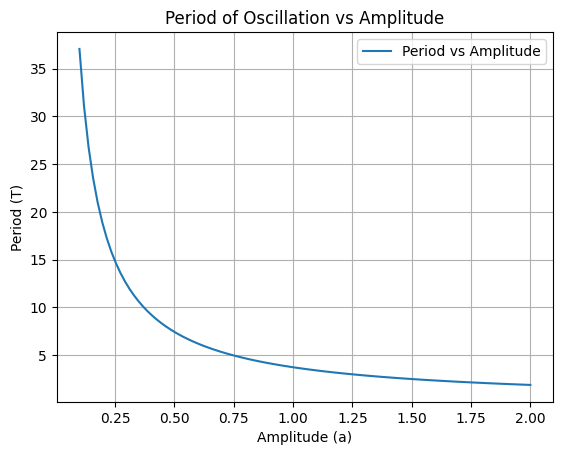

In [16]:
# Generate graph of period vs amplitude
a_values = np.linspace(0.1, 2, 100)  # Avoid zero to prevent singularity
T_values = [period_quad(a)[0] for a in a_values]

plt.plot(a_values, T_values, label='Period vs Amplitude')
plt.xlabel('Amplitude (a)')
plt.ylabel('Period (T)')
plt.title('Period of Oscillation vs Amplitude')
plt.legend()
plt.grid()
plt.show()